# NEB / CC Diagram Path Generation

Here we will generate the a set of linearly-interpolated structures along the transformation path from one defect to another (specifically the -1 and -2 charged selenium vacancies in [trigonal selenium](https://doi.org/10.1039/D4EE04647A)), which can be used to calculate the configuration coordinate (CC) diagram (i.e. potential energy surfaces of the two defect states) or as the initial guess for Nudged Elastic Band (NEB) calculations.

CC diagrams can then be used to compute non-radiative recombination rates with [`nonrad`](https://nonrad.readthedocs.io/en/latest/) and/or [`CarrierCapture.jl`](https://github.com/WMD-group/CarrierCapture.jl) ([Alkauskas et al. PRB 2014](https://doi.org/10.1103/PhysRevB.90.075202)), to predict optical transitions and their luminescence lineshapes ([Alkauskas et al. PRL 2012](https://doi.org/10.1103/PhysRevLett.109.267401)), to predict radiative recombination rates, and more.

Here we will generate the linearly-interpolated path between the -1 and -2 charged selenium vacancies in trigonal selenium, as was done to generate the CC diagram and compute their electron/hole charge capture rates (and thus contribution to non-radiative electron-hole recombination) in [this study](https://doi.org/10.1039/D4EE04647A).

In [1]:
from doped.thermodynamics import DefectThermodynamics
Se_intrinsic_thermo = DefectThermodynamics.from_json("Se/Se_Intrinsic_Thermo.json.gz")

In [3]:
V_Se_m1_supercell = Se_intrinsic_thermo["vac_1_Se_-1"].defect_supercell
V_Se_m2_supercell = Se_intrinsic_thermo["vac_1_Se_-2"].defect_supercell


Something that we need to be careful with when obtaining these interpolated structures, for both CC diagrams and NEB paths, is that they should be appropriately oriented relative to eachother, so that they are actually along the closest linear path between them. E.g. for a vacancy, the two vacancy supercells should have the vacancy in the same position in the supercell (so that we don't unintentionally model a long migration pathway!), and rotated so that the local environments most closely match eachother (essentially minimising the root-mean-square displacement between the geometries). A rough sketch of this point, showing the correct symmetry-equivalent orientation of $V^0$ to give the closest linear path to the $V^{+1}$ structure is shown below:

![](../docs/Images/Closest_Linear_Path.png)

To ensure we have the correct matching orientation, we can use the [`orient_s2_like_s1`](https://doped.readthedocs.io/en/latest/doped.utils.html#doped.utils.configurations.orient_s2_like_s1) function, which works similarly to the ``StructureMatcher.get_s2_like_s1`` method in ``pymatgen``, but accelerated and extended to ensure matching atomic indices and lattice vector definitions.

In [4]:
from doped.utils.configurations import orient_s2_like_s1

In [ ]:
# set verbose to True to show the difference in RMS displacement (assuming matched site indices) 
# between the original and re-oriented structures
V_Se_m2_like_m1 = orient_s2_like_s1(V_Se_m1_supercell, V_Se_m2_supercell, verbose=True)
# if we don't set verbose to True, there is no printed output here, just the re-oriented structure is returned

ΔQ(s1/s2) = 9.91 amu^(1/2)Å
ΔQ(s2_like_s1/s2) = 4.88 amu^(1/2)Å
ΔQ(s1/s2_like_s1) = 8.63 amu^(1/2)Å


Here we can see that the RMS displacement (assuming matched site indices) between the $V_{Se}^{-1}$ and $V_{Se}^{-2}$ structures has been reduced by reorienting (but not changing) the $V_{Se}^{-2}$ geometry, now corresponding to the closest linear path between symmetry-equivalent geometries of the two defects. We can confirm this by checking the structure symmetry and minimum interatomic distance before and after re-orientation:

In [21]:
from doped.utils.symmetry import point_symmetry_from_structure
from doped.utils.supercells import min_dist

# get the point group symmetry and minimum interatomic distances of the structures:
V_Se_m1_symm = point_symmetry_from_structure(V_Se_m1_supercell)
V_Se_m1_min_dist = min_dist(V_Se_m1_supercell)
V_Se_m2_symm = point_symmetry_from_structure(V_Se_m2_supercell)
V_Se_m2_min_dist = min_dist(V_Se_m2_supercell)
V_Se_m2_like_m1_symm = point_symmetry_from_structure(V_Se_m2_like_m1)
V_Se_m2_like_m1_min_dist = min_dist(V_Se_m2_like_m1)

for name, symm, min_dist in zip(
    ["V_Se^-1", "V_Se^-2 Original", "V_Se^-2 Reoriented"], 
    [V_Se_m1_symm, V_Se_m2_symm, V_Se_m2_like_m1_symm], 
    [V_Se_m1_min_dist, V_Se_m2_min_dist, V_Se_m2_like_m1_min_dist]
):
    print(f"{name} point group symmetry: {symm}, minimum interatomic distance: {min_dist:.2f} Å")

V_Se^-1 point group symmetry: C2, minimum interatomic distance: 2.30 Å
V_Se^-2 Original point group symmetry: C2, minimum interatomic distance: 2.33 Å
V_Se^-2 Reoriented point group symmetry: C2, minimum interatomic distance: 2.33 Å


Now we choose our set of structures along the linearly-interpolated path between $V_{Se}^{-1}$ and $V_{Se}^{-2}$ to compute, by specifying the fractional displacements along this path to generate the structures for. Here we will generate structures at the fractional displacements [-1.5, -1.2, -1.0, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5], in units of ΔQ (the displacement from structure to structure 2):

In [25]:
import numpy as np
positive_displacements = np.array([0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5])
displacements = np.concatenate([-positive_displacements[::-1], np.array([0.0]), positive_displacements])
print(displacements)

[-1.5 -1.2 -1.  -0.8 -0.6 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.6  0.8  1.   1.2  1.5]


Optional: We can generate and inspect the interpolated structures with [`get_path_structures`](https://doped.readthedocs.io/en/latest/doped.utils.html#doped.utils.configurations.get_path_structures):

In [26]:
from doped.utils.configurations import get_path_structures
disp_dict_m1, disp_dict_m2 = get_path_structures(
    V_Se_m1_supercell, V_Se_m2_like_m1, displacements=displacements)

In [27]:
disp_dict_m1.keys()

dict_keys(['delQ_-1.5', 'delQ_-1.2', 'delQ_-1.0', 'delQ_-0.8', 'delQ_-0.6', 'delQ_-0.4', 'delQ_-0.3', 'delQ_-0.2', 'delQ_-0.1', 'delQ_0.0', 'delQ_0.1', 'delQ_0.2', 'delQ_0.3', 'delQ_0.4', 'delQ_0.6', 'delQ_0.8', 'delQ_1.0', 'delQ_1.2', 'delQ_1.5'])

In [29]:
disp_dict_m1["delQ_0.6"]

Structure Summary
Lattice
    abc : 13.032718 13.03271811400469 14.890713999999997
 angles : 90.0 90.0 119.99999971063251
 volume : 2190.3633066388306
      A : np.float64(13.032718) np.float64(0.0) np.float64(0.0)
      B : np.float64(-6.516359) np.float64(11.286664999999998) np.float64(0.0)
      C : np.float64(0.0) np.float64(0.0) np.float64(14.890713999999997)
    pbc : True True True
PeriodicSite: Se (0.981, 0.04976, 6.643) [0.07748, 0.004408, 0.4461]
PeriodicSite: Se (-5.543, 11.24, 11.57) [0.07242, 0.9955, 0.7772]
PeriodicSite: Se (-1.25, 3.787, 1.663) [0.0719, 0.3356, 0.1117]
PeriodicSite: Se (-1.259, 3.769, 6.614) [0.07039, 0.334, 0.4442]
PeriodicSite: Se (-1.281, 3.837, 11.59) [0.07167, 0.3399, 0.7782]
PeriodicSite: Se (-3.457, 7.603, 1.674) [0.07153, 0.6736, 0.1124]
PeriodicSite: Se (-3.435, 7.61, 6.606) [0.07351, 0.6742, 0.4436]
PeriodicSite: Se (-3.512, 7.665, 11.63) [0.07007, 0.6791, 0.781]
PeriodicSite: Se (-1.138, 11.28, 1.649) [0.4122, 0.9991, 0.1108]
PeriodicSite: Se 

We can directly write the interpolated structures to file, to use for VASP calculations to generate our CC diagram / NEB initial guess (in which case we'd set ``n_images`` rather than ``displacements`` for ``get_path_structures``/``write_path_structures``) using [`write_path_structures`](https://doped.readthedocs.io/en/latest/doped.utils.html#doped.utils.configurations.write_path_structures):

In [30]:
from doped.utils.configurations import write_path_structures

write_path_structures(
    V_Se_m1_supercell, V_Se_m2_like_m1, displacements=displacements, output_dir="V_Se_-1_to_-2"
)

In [33]:
!ls V_Se_-1_to_-2

PES_1 PES_2


In [34]:
!ls V_Se_-1_to_-2/PES_1

delQ_-0.1 delQ_-0.4 delQ_-1.0 delQ_0.0  delQ_0.3  delQ_0.8  delQ_1.5
delQ_-0.2 delQ_-0.6 delQ_-1.2 delQ_0.1  delQ_0.4  delQ_1.0
delQ_-0.3 delQ_-0.8 delQ_-1.5 delQ_0.2  delQ_0.6  delQ_1.2


In [35]:
!ls V_Se_-1_to_-2/PES_1/delQ_0.6

POSCAR


```{note}
The same workflow applies for generating initial guess structures for NEB paths, but the ``n_images`` argument should then be used with ``get_path_structures``/`write_path_structures`.
```

See the [`nonrad`](https://nonrad.readthedocs.io/en/latest/) and/or [`CarrierCapture.jl`](https://github.com/WMD-group/CarrierCapture.jl) tutorials for examples of plotting and analysis of the results of these calculations.

# NEB Between Crystal Polymorphs

These functions can also be very useful when one wants to perform NEB calculations (or simply singlepoint calculations along an interpolated path) between different crystal structures – as performed in [this study on AgBiS₂ – TODO]()

In this example, we want to calculate the minimum energy pathway along the structural PES from the $R\bar{3}m$ structure (previously thought to be the ordered ground-state of AgBiS₂) and the recently-discovered $P3_221$ phase:

In [1]:
from pymatgen.core.structure import Structure

RPA_R3m = Structure.from_file("AgBiS2/R-3m_RPA_PBE_Min_Energy_Relaxed_CONTCAR")
RPA_P3_221 = Structure.from_file("AgBiS2/P3_221_RPA_PBE_Min_Energy_Relaxed_CONTCAR")

In [2]:
RPA_R3m.lattice

Lattice
    abc : 6.741702332938467 6.741702275281131 6.741702747042641
 angles : 34.537890604070625 34.53789369373768 34.53788801879599
 volume : 87.87241365397952
      A : np.float64(3.8313124954623725) np.float64(0.0067957894543121) np.float64(5.5472108960546604)
      B : np.float64(1.7344427349110751) np.float64(3.416241975347925) np.float64(5.547210896812548)
      C : np.float64(0.01104923956544) np.float64(0.0067957900781565) np.float64(6.7416902673605925)
    pbc : True True True

In [3]:
RPA_P3_221.lattice

Lattice
    abc : 4.0672456500258996 4.0672456500258996 19.281437325056643
 angles : 90.0 90.0 119.99999999999999
 volume : 276.22999999999973
      A : np.float64(4.0672456500258996) np.float64(1.2e-15) np.float64(1e-16)
      B : np.float64(-2.0336228250129498) np.float64(3.522338056354181) np.float64(3e-16)
      C : np.float64(-4e-16) np.float64(2e-16) np.float64(19.281437325056643)
    pbc : True True True

As we can see, the unit cell sizes and lattice vectors differ for these two polymorphs, so we need to determine commensurate supercell sizes to perform our NEB calculation. There is no visually-obvious supercell conversion here, so let's see what the conventional cell definitions look like:

In [4]:
from doped.utils.symmetry import get_BCS_conventional_structure

R3m_conv_struct = get_BCS_conventional_structure(RPA_R3m)[0]
R3m_conv_struct.lattice


Lattice
    abc : 4.002647591940581 4.002647591940581 18.999773676
 angles : 90.0 90.0 119.99999999901789
 volume : 263.6172159502596
      A : np.float64(2.001323796) np.float64(-3.466394497) np.float64(0.0)
      B : np.float64(2.001323796) np.float64(3.466394497) np.float64(0.0)
      C : np.float64(0.0) np.float64(0.0) np.float64(18.999773676)
    pbc : True True True

Great, in this case the conventional cell definition for $R\bar{3}m$ matches that of $P3_221$, so we can use this. Alternatively, we could also have tried using the ``Lattice.find_all_mappings()`` method from ``pymatgen``, with adjusted ``ltol`` and ``atol``, to help find commensurate cell sizes.

As above, we need to ensure matching orientation and atomic indices between our structures, so that our NEB initial guess corresponds to the closest linear path between these structures:

In [5]:
from doped.utils.configurations import orient_s2_like_s1

RPA_R3m_like_P3_221 = orient_s2_like_s1(RPA_P3_221, R3m_conv_struct)


/Users/kavanase/Packages/doped/doped/utils/configurations.py:70: UserWarning: The lattices of the two input structures have been detected to be (symmetry-)inequivalent. This is usually not desirable for defect NEBs/CC diagrams, but may be the case for e.g. NEBs between polymorphs. 
  warnings.warn(
/Users/kavanase/Packages/doped/doped/utils/configurations.py:76: UserWarning: Note that the lattice definitions may differ between the output structure and ``struct1``. See the NEB/CC diagram tutorial for details.
  warnings.warn(


Here we get a warning about these being inequivalent lattices, which is typically not desired for defect CCD/NEB calculations, but is expected in this case. We also get a warning that the lattice definitions for the two structures might still differ in this case, due to difficulties introduced with the symmetry-inequivalent lattices. Let's check:

In [6]:
RPA_R3m_like_P3_221.lattice

Lattice
    abc : 4.002647591940581 4.002647592 18.999773676
 angles : 90.0 90.0 120.00000000049107
 volume : 263.6172159502596
      A : np.float64(-2.001323796) np.float64(-3.466394497) np.float64(0.0)
      B : np.float64(4.002647592) np.float64(0.0) np.float64(0.0)
      C : np.float64(0.0) np.float64(0.0) np.float64(-18.999773676)
    pbc : True True True

In [7]:
RPA_P3_221.lattice

Lattice
    abc : 4.0672456500258996 4.0672456500258996 19.281437325056643
 angles : 90.0 90.0 119.99999999999999
 volume : 276.22999999999973
      A : np.float64(4.0672456500258996) np.float64(1.2e-15) np.float64(1e-16)
      B : np.float64(-2.0336228250129498) np.float64(3.522338056354181) np.float64(3e-16)
      C : np.float64(-4e-16) np.float64(2e-16) np.float64(19.281437325056643)
    pbc : True True True

Here we can see that the lattice vectors are equivalent, but with different definitions (e.g. the `B` vector for `RPA_R3m_like_P3_221` matches the `A` vector for `RPA_P3_221`). Here we redefine our lattice for `RPA_R3m_like_P3_221` to give the closest match to that of `RPA_P3_221` (note that we avoid just directly using the lattice of `RPA_P3_221` here, as this corresponds to a different space group (despite being similar)):

In [9]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.sites import PeriodicSite
import numpy as np

RPA_R3m_like_P3_221_lattice = Lattice(np.array([
    RPA_R3m_like_P3_221.lattice.matrix[1],  # B -> A
    [
        RPA_R3m_like_P3_221.lattice.matrix[0][0], 
        -RPA_R3m_like_P3_221.lattice.matrix[0][1], 
        RPA_R3m_like_P3_221.lattice.matrix[0][2]],  # flip sign of A y coordinate to match P3_221 definition, and set to B vector
    -RPA_R3m_like_P3_221.lattice.matrix[2]  # -C -> C
    ])
)  # Note that these are fully equivalent lattice definitions

RPA_R3m_like_P3_221_w_matching_lattice = Structure.from_sites(
    [
            PeriodicSite(
                site.specie,
                site.frac_coords,
                RPA_R3m_like_P3_221_lattice,
                properties=site.properties,
                to_unit_cell=True,
            )
            for site in RPA_R3m_like_P3_221.sites
        ]
    )

Visually confirm matching atomic indices (similar fractional coordinates for site 1, 2, 3 etc in both structures):

In [10]:
RPA_R3m_like_P3_221_w_matching_lattice

Structure Summary
Lattice
    abc : 4.002647592 4.002647591940581 18.999773676
 angles : 90.0 90.0 120.00000000049107
 volume : 263.6172159502596
      A : np.float64(4.002647592) np.float64(0.0) np.float64(0.0)
      B : np.float64(-2.001323796) np.float64(3.466394497) np.float64(0.0)
      C : np.float64(-0.0) np.float64(-0.0) np.float64(18.999773676)
    pbc : True True True
PeriodicSite: Ag (0.6671, 3.466, 3.167) [0.6667, 1.0, 0.1667]
PeriodicSite: Ag (0.6671, 1.155, 9.5) [0.3333, 0.3333, 0.5]
PeriodicSite: Ag (-1.334, 2.311, 15.83) [0.0, 0.6667, 0.8333]
PeriodicSite: Bi (0.6671, 3.466, 12.67) [0.6667, 1.0, 0.6667]
PeriodicSite: Bi (0.6671, 1.155, 1.647e-07) [0.3333, 0.3333, 8.667e-09]
PeriodicSite: Bi (-1.334, 2.311, 6.333) [0.0, 0.6667, 0.3333]
PeriodicSite: S (0.6671, 1.155, 14.3) [0.3333, 0.3333, 0.7524]
PeriodicSite: S (-1.334, 2.311, 1.629) [0.0, 0.6667, 0.08576]
PeriodicSite: S (0.6671, 3.466, 7.963) [0.6667, 1.0, 0.4191]
PeriodicSite: S (0.6671, 1.155, 4.704) [0.3333, 0.333

In [11]:
RPA_P3_221

Structure Summary
Lattice
    abc : 4.0672456500258996 4.0672456500258996 19.281437325056643
 angles : 90.0 90.0 119.99999999999999
 volume : 276.22999999999973
      A : np.float64(4.0672456500258996) np.float64(1.2e-15) np.float64(1e-16)
      B : np.float64(-2.0336228250129498) np.float64(3.522338056354181) np.float64(3e-16)
      C : np.float64(-4e-16) np.float64(2e-16) np.float64(19.281437325056643)
    pbc : True True True
PeriodicSite: Ag (2.874, 8.812e-16, 3.214) [0.7066, -0.0, 0.1667]
PeriodicSite: Ag (0.5967, 1.033, 9.641) [0.2934, 0.2934, 0.5]
PeriodicSite: Ag (-1.437, 2.489, 16.07) [-0.0, 0.7066, 0.8333]
PeriodicSite: Bi (3.047, 1.032e-15, 12.85) [0.7491, 0.0, 0.6667]
PeriodicSite: Bi (0.5102, 0.8837, 1.003e-16) [0.2509, 0.2509, -0.0]
PeriodicSite: Bi (-1.523, 2.639, 6.427) [-0.0, 0.7491, 0.3333]
PeriodicSite: S (1.264, 1.192, 14.46) [0.4801, 0.3385, 0.7498]
PeriodicSite: S (2.434, 1.831, 1.602) [0.8584, 0.5199, 0.0831]
PeriodicSite: S (2.403, 0.4988, 8.029) [0.6615, 0.1416

In [12]:
# confirm our space group is correct:
RPA_R3m_like_P3_221_w_matching_lattice.get_space_group_info()

('R-3m', 166)

Now we can write our interpolated structures to file and use them for NEB calculations:

In [13]:
from doped.utils.configurations import write_path_structures

write_path_structures(
    RPA_R3m_like_P3_221_w_matching_lattice, RPA_P3_221, n_images=6, output_dir="AgBiS2/R-3m_to_P3_221"
)  # here we set n_images to generate one set of evenly-spaced structures along the linear path, to use
# for NEB calculations

In [14]:
!ls AgBiS2/R-3m_to_P3_221

00 01 02 03 04 05 06


In [15]:
!ls AgBiS2/R-3m_to_P3_221/03

POSCAR


Results:

([<matplotlib.axis.XTick at 0x3054a4550>,
 [Text(0, 0, '$P3_221$'), Text(7, 0, '$R\\bar{3}m$'), Text(14, 0, '$P3_221$')])

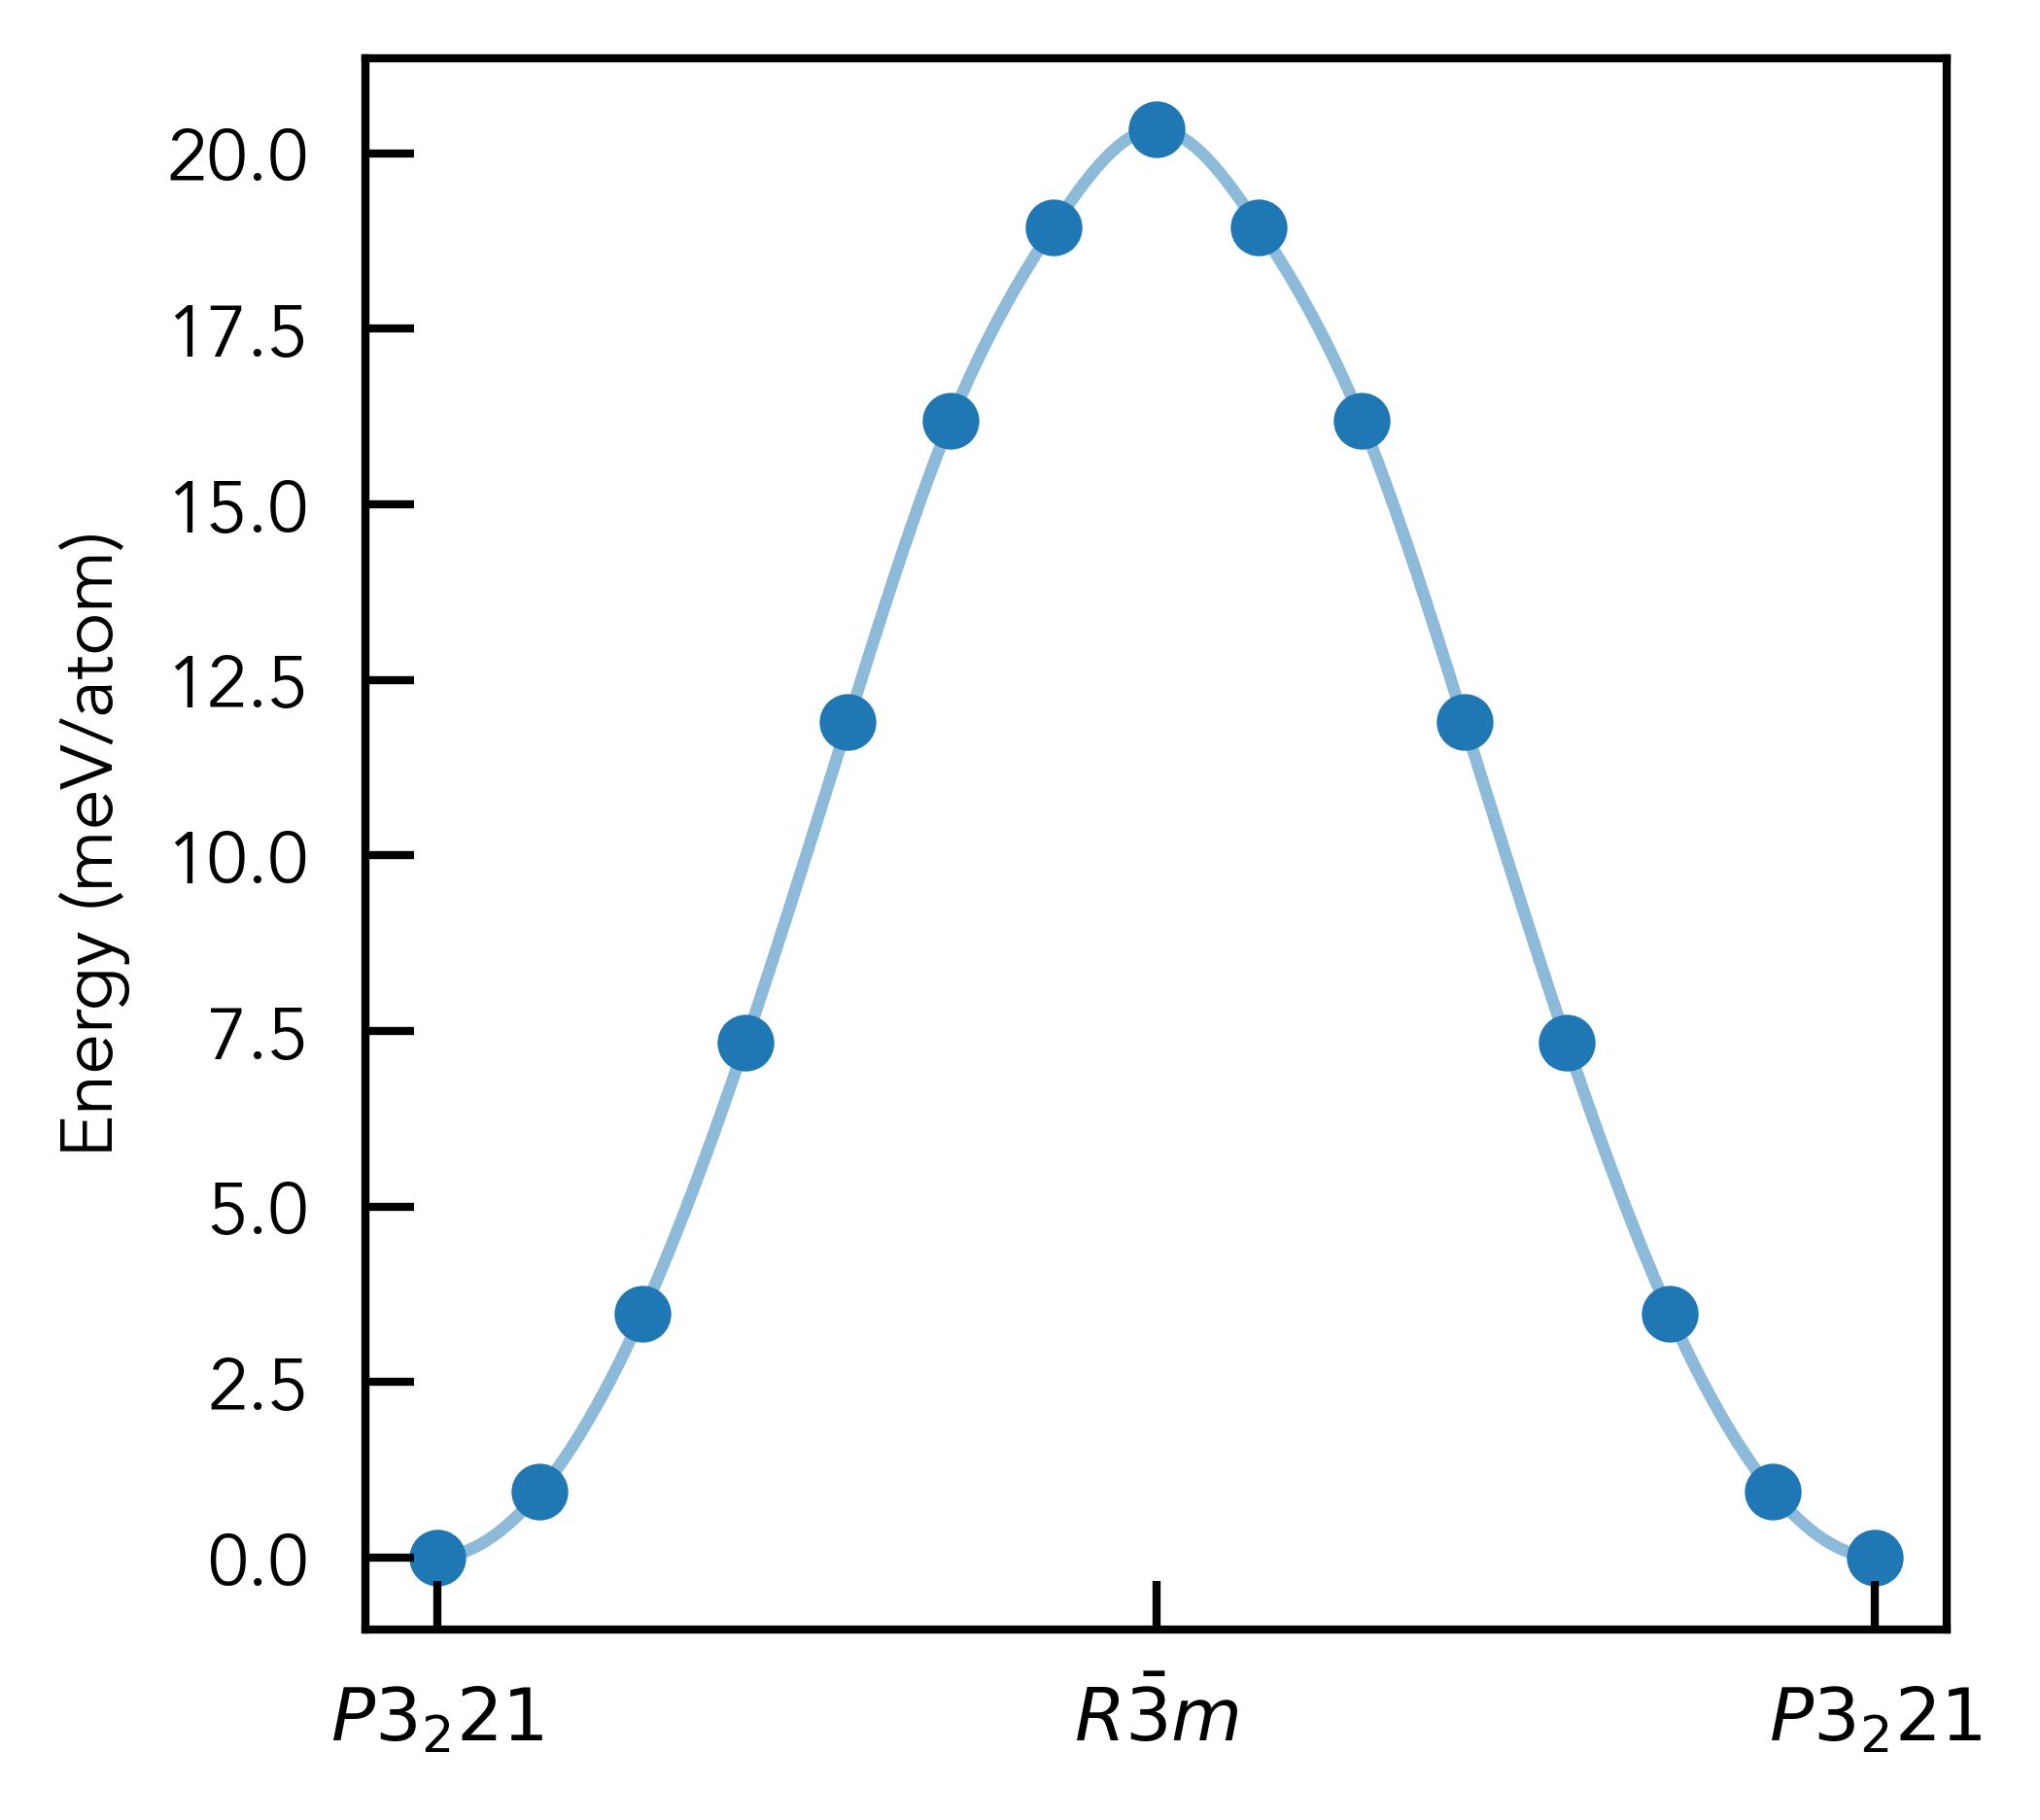

In [26]:
# plot final energies from NEB calculations:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("~/Packages/publication_style.mplstyle")

energies = np.array([
    -56.62423270,
    -56.64091892,
    -56.67399708,
    -56.72550242,
    -56.78033792,
    -56.82650156,
    -56.85690367,
    -56.86827542,
])
energies -= np.min(energies)
energies_per_atom = (energies/len(RPA_R3m_like_P3_221_w_matching_lattice))*1000  # meV/atom
# mirror around 0, because we have two equivalent R-3m -> P3_221 distortion paths
energies_per_atom = np.concatenate([energies_per_atom[::-1], energies_per_atom[1:]])

# interpolate:
from scipy.interpolate import CubicSpline

spl = CubicSpline(np.arange(len(energies_per_atom)), energies_per_atom)
x_interp = np.linspace(0, len(energies_per_atom)-1, 1000)
y_interp = spl(x_interp)
plt.plot(x_interp, y_interp, alpha=0.5)
plt.scatter(np.arange(len(energies_per_atom)), energies_per_atom, marker='o')
plt.ylabel("Energy (meV/atom)")

# set x-labels as space group symbols:
plt.xticks(
    [0, len(energies_per_atom)//2, len(energies_per_atom)-1], [r"$P3_221$", r"$R\bar{3}m$", r"$P3_221$"]
)


In [27]:
# tutorial cleanup:
!rm -r AgBiS2/R-3m_to_P3_221
!rm -r V_Se_-1_to_-2